# Interactive Bath Model Analysis

This notebook provides an interactive analysis of different bosonic bath models used in quantum optics and open quantum systems. It allows comparison between different bath types and their spectral properties.

## Table of Contents
1. [Setup and Imports](#setup)
2. [Bath Model Definitions](#definitions)
3. [Interactive Parameter Controls](#controls)
4. [Bath Comparison Analysis](#comparison)
5. [Temperature Effects](#temperature)
6. [Correlation Function Analysis](#correlation)

### Discussion: Units of Spectral Density in Different Conventions
$J(\omega)$ describes the spectral density of environmental modes at a given frequency $\omega$ and how strongly these modes couple to the system.
In the [paper](https://pubs.aip.org/aip/jcp/article/124/23/234505/930637/Two-dimensional-optical-three-pulse-photon-echo), **spectroscopic units of cm⁻¹** are used for transition frequencies ("wavenumbers"). The spectral density is defined as:
$$
J(\omega) = g^2 \frac{\omega}{\omega_c} \exp\left(-\frac{\omega}{\omega_c}\right)
$$
where:
- $g$ is the dimensionless coupling strength,
- $\omega_c$ is the cutoff frequency,
- $\omega$ is the frequency.

**Units:**  
- $J(\omega)$ is dimensionless in this context.


In **QuTiP**, the Ohmic spectral density is typically written as:
$$
J(\omega) = \alpha \frac{\omega^s}{\omega_c^{s-1}} \exp\left(-\frac{\omega}{\omega_c}\right)
$$
For the Ohmic case ($s = 1$):
$$
J(\omega) = \alpha \omega \exp\left(-\frac{\omega}{\omega_c}\right)
$$
where:
- $\alpha$ is the dimensionless coupling strength,
- $\omega_c$ is the cutoff frequency,
- $\omega$ is the frequency.

**Units:**  
- $J(\omega)$ now has units of frequency ($[\omega]$).


#### Physical Meaning

According to [Wikipedia](https://en.wikipedia.org/wiki/Spectral_density), the spectral density $J(\omega)$ represents the **amount of power per unit frequency range**. ---

**References:**  
- Weiss, U. (2012). Quantum Dissipative Systems.

$$
H_{\text{SB}} = \Sigma_i F_i Aᵢ
$$

$$
[\mathbf{A}_i] = \left[\mu\right] = 1  \quad \text{(dimensionless (in the paper))}
$$

$$
[H_{\text{SB}}] = \left[J\right] = \left[eV\right]
$$

Then:
$$
[F_i] = \left[ J\right] = \left[eV\right]
$$

And:
$$
[g_x^i] = \left[ J\right] = \left[eV\right] = \left[ \omega\right] \text{(because [hbar]=1)}
$$

$$
[J_i(\omega)] = [g_x^{i\,2} \, \delta(\omega)] = \left[\omega\right] \text{(matches the Qutip definition)}
$$
But now:
$$
[J(\omega)] = [g^2] ?=? \left[\omega^2\right]
$$


**Actually the coupling constant in the paper is Not dimensionless**


In [1]:
# =============================
# SETUP AND IMPORTS
# =============================
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from qutip import BosonicEnvironment
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

# Import bath functions
from src.baths. bath_fcts import *
from src.visualization import mpl_tex_settings

# Set matplotlib backend and style
mpl.use("inline")
plt.style.use('default')

## Bath Model Definitions

We analyze three main types of bosonic baths:

1. **Paper Bath**: Exponential cutoff spectral density as used in the research paper
2. **Ohmic Bath**: Power-law spectral density with exponential cutoff  
3. **Drude-Lorentz Bath**: Lorentzian spectral density commonly used in condensed matter

Each bath is characterized by its spectral density $J(\omega)$ and power spectrum $S(\omega)$.

In [2]:
# =============================
# BATH MODEL CONSTANTS AND PARAMETERS
# =============================

# Physical constants (normalized units)
Boltzmann = 1.0  # Boltzmann constant
hbar = 1.0       # Reduced Planck constant

# Default parameter sets for different bath types
def get_default_parameters():
    """Get default parameter sets for all bath types"""
    
    # Base parameters
    Temp = 1e-2      # Temperature
    eta = 1e-2       # Dimensionless coupling strength
    cutoff = 1e2     # Cutoff frequency
    
    # Paper bath parameters
    args_paper = {
        "g": np.sqrt(eta * cutoff),
        "cutoff": cutoff,
        "Boltzmann": Boltzmann,
        "hbar": hbar,
        "Temp": Temp,
    }
    
    # Ohmic bath parameters
    args_ohmic = {
        "eta": eta,
        "cutoff": cutoff,
        "s": 1.0,
        "Boltzmann": Boltzmann,
        "Temp": Temp,
    }
    
    # Drude-Lorentz bath parameters
    args_drude_lorentz = {
        "lambda": eta * cutoff / 2, 
        "cutoff": cutoff
    }
    
    return args_paper, args_ohmic, args_drude_lorentz

# Get default parameters
args_paper, args_ohmic, args_drude_lorentz = get_default_parameters()

print("🔧 Default bath parameters loaded:")
print(f"   Temperature: {args_paper['Temp']:.1e}")
print(f"   Coupling η: {args_ohmic['eta']:.1e}")
print(f"   Cutoff: {args_paper['cutoff']:.1e}")

🔧 Default bath parameters loaded:
   Temperature: 1.0e-02
   Coupling η: 1.0e-02
   Cutoff: 1.0e+02


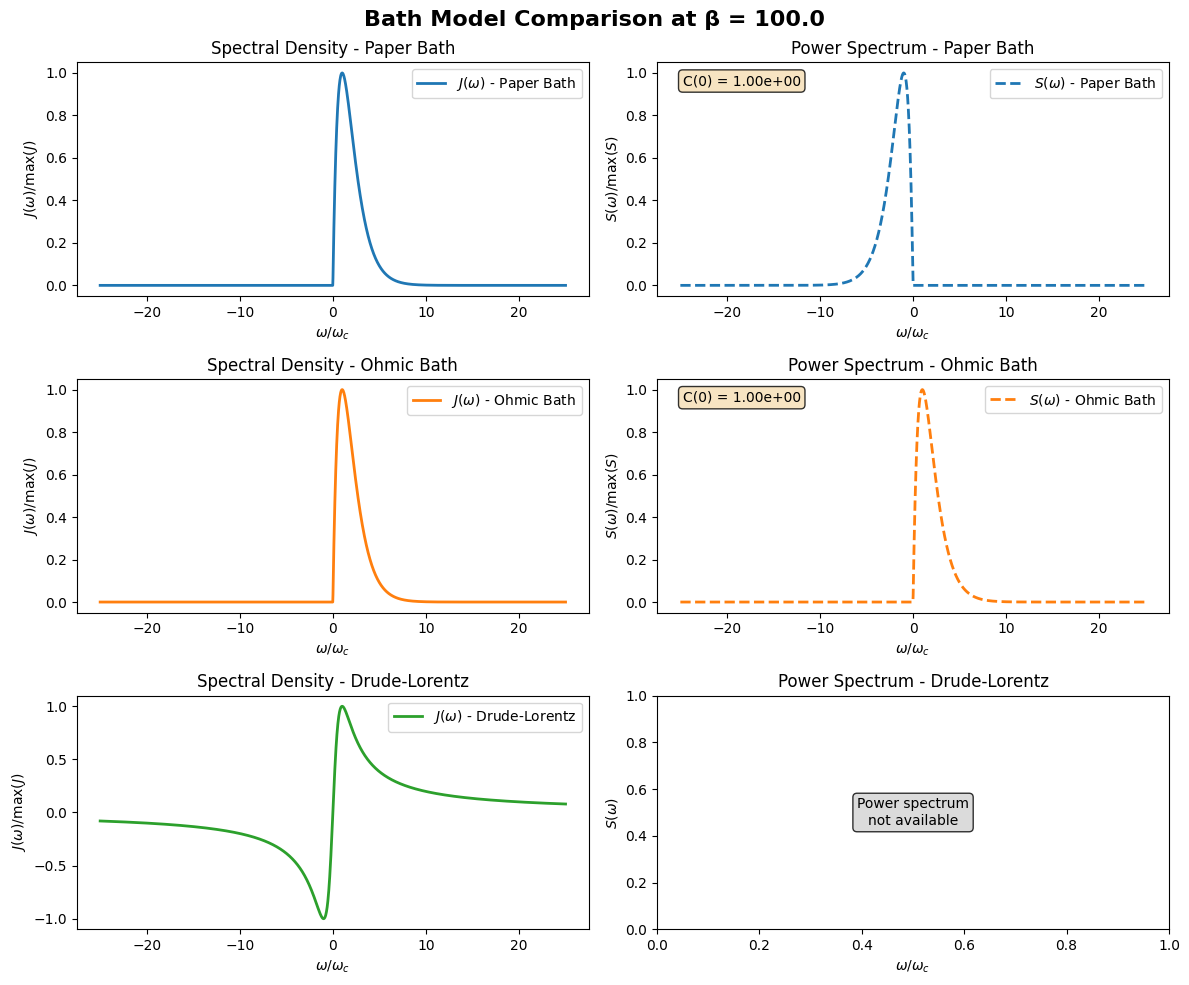

In [3]:
# =============================
# ENHANCED PLOTTING FUNCTIONS
# =============================

def plot_bath_comparison(frequencies_range=(-25, 25), num_points=2000, figsize=(12, 10)):
    """
    Compare all three bath types in a comprehensive plot
    """
    cutoff = args_paper["cutoff"]
    
    # Generate frequency and time ranges
    frequencies = np.linspace(
        frequencies_range[0] * cutoff, 
        frequencies_range[1] * cutoff, 
        num_points
    )
    times = np.linspace(
        frequencies_range[0] / cutoff, 
        frequencies_range[1] / cutoff, 
        num_points
    )
    
    normalized_frequencies = frequencies / cutoff
    normalized_times = times * cutoff
    
    # Create figure with subplots
    fig, axes = plt.subplots(3, 2, figsize=figsize)
    fig.suptitle(f'Bath Model Comparison at β = {1/(Boltzmann * args_paper["Temp"]):.1f}', 
                 fontsize=16, fontweight='bold')
    
    # Bath configurations
    bath_configs = [
        ("Paper Bath", spectral_density_func_paper, Power_spectrum_func_paper, args_paper, 'C0'),
        ("Ohmic Bath", spectral_density_func_ohmic, Power_spectrum_func_ohmic, args_ohmic, 'C1'),
        ("Drude-Lorentz", spectral_density_func_drude_lorentz, None, args_drude_lorentz, 'C2')
    ]
    
    for i, (name, J_func, S_func, args, color) in enumerate(bath_configs):
        
        # Calculate spectral density
        if name == "Drude-Lorentz":
            J_vals = np.array([J_func(w, args) for w in frequencies])
            S_vals = None  # No power spectrum function for D-L in current implementation
        else:
            J_vals = np.array([J_func(w, args) for w in frequencies])
            if S_func:
                S_vals = S_func(frequencies, args) if name == "Paper Bath" else np.array([S_func(w, args) for w in frequencies])
        
        # Plot spectral density
        ax1 = axes[i, 0]
        J_max = np.max(np.abs(J_vals[J_vals > 0])) if np.any(J_vals > 0) else 1
        ax1.plot(normalized_frequencies, J_vals / J_max, 
                label=f'$J(ω)$ - {name}', color=color, linewidth=2)
        ax1.set_xlabel(r'$ω / ω_c$')
        ax1.set_ylabel(r'$J(ω) / \max(J)$')
        ax1.set_title(f'Spectral Density - {name}')
        ax1.legend()
        
        # Plot power spectrum (if available)
        ax2 = axes[i, 1]
        if S_vals is not None and name != "Drude-Lorentz":
            S_max = np.max(np.abs(S_vals)) if np.any(S_vals != 0) else 1
            ax2.plot(normalized_frequencies, S_vals / S_max, 
                    label=f'$S(ω)$ - {name}', color=color, linewidth=2, linestyle='--')
            ax2.set_xlabel(r'$ω / ω_c$')
            ax2.set_ylabel(r'$S(ω) / \max(S)$')
            ax2.set_title(f'Power Spectrum - {name}')
            ax2.legend()
            
            # Add correlation function using QuTiP
            try:
                if name == "Paper Bath":
                    env = BosonicEnvironment.from_power_spectrum(
                        lambda w: Power_spectrum_func_paper(w, args), 
                        wMax=10 * cutoff, T=args["Temp"]
                    )
                else:
                    env = BosonicEnvironment.from_spectral_density(
                        lambda w: J_func(w, args), 
                        wMax=10 * cutoff, T=args["Temp"]
                    )
                
                correlation_vals = env.correlation_function(times)
                C_max = np.max(np.abs(correlation_vals)) if np.any(correlation_vals != 0) else 1
                
                # Add correlation info as text
                ax2.text(0.05, 0.95, f'C(0) = {np.abs(correlation_vals[len(correlation_vals)//2])/C_max:.2e}', 
                        transform=ax2.transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
                        
            except Exception as e:
                ax2.text(0.5, 0.5, f'QuTiP error:\n{str(e)[:50]}...', 
                        transform=ax2.transAxes, ha='center', va='center',
                        bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
        else:
            ax2.text(0.5, 0.5, 'Power spectrum\nnot available', 
                    transform=ax2.transAxes, ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
            ax2.set_xlabel(r'$ω / ω_c$')
            ax2.set_ylabel(r'$S(ω)$')
            ax2.set_title(f'Power Spectrum - {name}')
    
    plt.tight_layout()
    return fig, axes

# Test the comparison function
fig, axes = plot_bath_comparison()
plt.show()

## Interactive Parameter Controls

Use the controls below to explore how different parameters affect the bath properties:

In [4]:
# =============================
# INTERACTIVE* PARAMETER CONTROLS
# =============================

def create_interactive_controls():
    """Create interactive widgets for parameter exploration"""
    
    # Parameter sliders
    temp_slider = widgets.FloatLogSlider(
        value=1e-2,
        base=10,
        min=-4, max=2,
        step=0.1,
        description='Temperature:',
        readout_format='.2e',
        style={'description_width': 'initial'}
    )
    
    eta_slider = widgets.FloatLogSlider(
        value=1e-2,
        base=10,
        min=-4, max=0,
        step=0.1,
        description='Coupling η:',
        readout_format='.2e',
        style={'description_width': 'initial'}
    )
    
    cutoff_slider = widgets.FloatLogSlider(
        value=1e2,
        base=10,
        min=0, max=3,
        step=0.1,
        description='Cutoff ωc:',
        readout_format='.1e',
        style={'description_width': 'initial'}
    )
    
    freq_range_slider = widgets.IntRangeSlider(
        value=[-25, 25],
        min=-100, max=100,
        step=5,
        description='Freq Range:',
        style={'description_width': 'initial'}
    )
    
    bath_selector = widgets.SelectMultiple(
        options=['Paper Bath', 'Ohmic Bath', 'Drude-Lorentz'],
        value=['Paper Bath', 'Ohmic Bath'],
        description='Bath Types:',
        style={'description_width': 'initial'}
    )
    
    plot_type = widgets.RadioButtons(
        options=['Spectral Density', 'Power Spectrum', 'Both'],
        value='Both',
        description='Plot Type:',
        style={'description_width': 'initial'}
    )
    
    return temp_slider, eta_slider, cutoff_slider, freq_range_slider, bath_selector, plot_type

def interactive_bath_plot(temp, eta, cutoff, freq_range, selected_baths, plot_type):
    """Interactive plotting function"""
    
    # Update parameters
    current_args_paper = {
        "g": np.sqrt(eta * cutoff),
        "cutoff": cutoff,
        "Boltzmann": Boltzmann,
        "hbar": hbar,
        "Temp": temp,
    }
    
    current_args_ohmic = {
        "eta": eta,
        "cutoff": cutoff,
        "s": 1.0,
        "Boltzmann": Boltzmann,
        "Temp": temp,
    }
    
    current_args_drude_lorentz = {
        "lambda": eta * cutoff / 2, 
        "cutoff": cutoff
    }
    
    # Generate data
    frequencies = np.linspace(freq_range[0] * cutoff, freq_range[1] * cutoff, 1000)
    normalized_frequencies = frequencies / cutoff
    
    # Determine subplot layout
    n_plots = len(selected_baths)
    if plot_type == 'Both':
        fig, axes = plt.subplots(n_plots, 2, figsize=(12, 4*n_plots))
        if n_plots == 1:
            axes = axes.reshape(1, -1)
    else:
        fig, axes = plt.subplots(n_plots, 1, figsize=(8, 4*n_plots))
        if n_plots == 1:
            axes = [axes]
    
    fig.suptitle(f'Bath Analysis: T={temp:.1e}, η={eta:.1e}, ωc={cutoff:.1e}', 
                 fontsize=14, fontweight='bold')
    
    colors = ['C0', 'C1', 'C2']
    
    for i, bath_name in enumerate(selected_baths):
        color = colors[i % len(colors)]
        
        if bath_name == 'Paper Bath':
            args = current_args_paper
            J_func = spectral_density_func_paper
            S_func = lambda w_arr, args: Power_spectrum_func_paper(w_arr, args)
        elif bath_name == 'Ohmic Bath':
            args = current_args_ohmic
            J_func = spectral_density_func_ohmic
            S_func = lambda w_arr, args: np.array([Power_spectrum_func_ohmic(w, args) for w in w_arr])
        else:  # Drude-Lorentz
            args = current_args_drude_lorentz
            J_func = spectral_density_func_drude_lorentz
            S_func = None
        
        # Calculate spectral density
        J_vals = np.array([J_func(w, args) for w in frequencies])
        J_max = np.max(np.abs(J_vals[J_vals > 0])) if np.any(J_vals > 0) else 1
        
        if plot_type in ['Spectral Density', 'Both']:
            ax_idx = (i, 0) if plot_type == 'Both' else i
            ax = axes[ax_idx] if plot_type == 'Both' else axes[i]
            
            ax.plot(normalized_frequencies, J_vals / J_max, 
                   label=f'$J(ω)$ - {bath_name}', color=color, linewidth=2)
            ax.set_xlabel(r'$ω / ω_c$')
            ax.set_ylabel(r'$J(ω) / \max(J)$')
            ax.set_title(f'Spectral Density - {bath_name}')
            ax.legend()
        
        if plot_type in ['Power Spectrum', 'Both'] and S_func is not None:
            ax_idx = (i, 1) if plot_type == 'Both' else i
            ax = axes[ax_idx] if plot_type == 'Both' else axes[i]
            
            S_vals = S_func(frequencies, args)
            S_max = np.max(np.abs(S_vals)) if np.any(S_vals != 0) else 1
            
            ax.plot(normalized_frequencies, S_vals / S_max, 
                   label=f'$S(ω)$ - {bath_name}', color=color, linewidth=2, linestyle='--')
            ax.set_xlabel(r'$ω / ω_c$')
            ax.set_ylabel(r'$S(ω) / \max(S)$')
            ax.set_title(f'Power Spectrum - {bath_name}')
            ax.legend()
    
    plt.tight_layout()
    plt.show()

# Create and display interactive controls
temp_slider, eta_slider, cutoff_slider, freq_range_slider, bath_selector, plot_type = create_interactive_controls()

# Display controls
print("🎛️ Interactive Bath Analysis Controls:")
display(widgets.VBox([
    widgets.HBox([temp_slider, eta_slider]),
    widgets.HBox([cutoff_slider, freq_range_slider]),
    widgets.HBox([bath_selector, plot_type])
]))

# Create interactive plot
interactive_plot = widgets.interactive(
    interactive_bath_plot,
    temp=temp_slider,
    eta=eta_slider,
    cutoff=cutoff_slider,
    freq_range=freq_range_slider,
    selected_baths=bath_selector,
    plot_type=plot_type
)

display(interactive_plot)

🎛️ Interactive Bath Analysis Controls:


interactive(children=(FloatLogSlider(value=0.01, description='Temperature:', max=2.0, min=-4.0, readout_format…

## Temperature Effects Analysis

Explore how temperature affects the bath properties, particularly the power spectrum and correlation functions:

🌡️ Analyzing temperature effects...


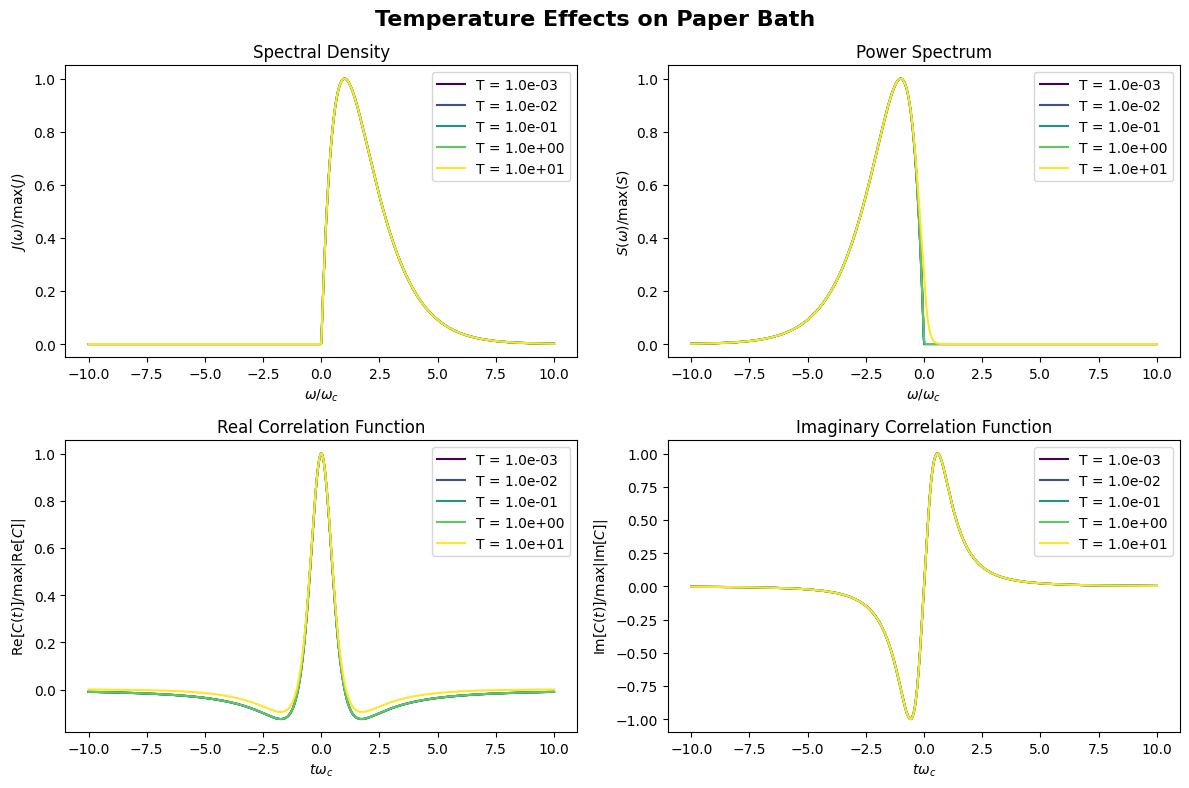

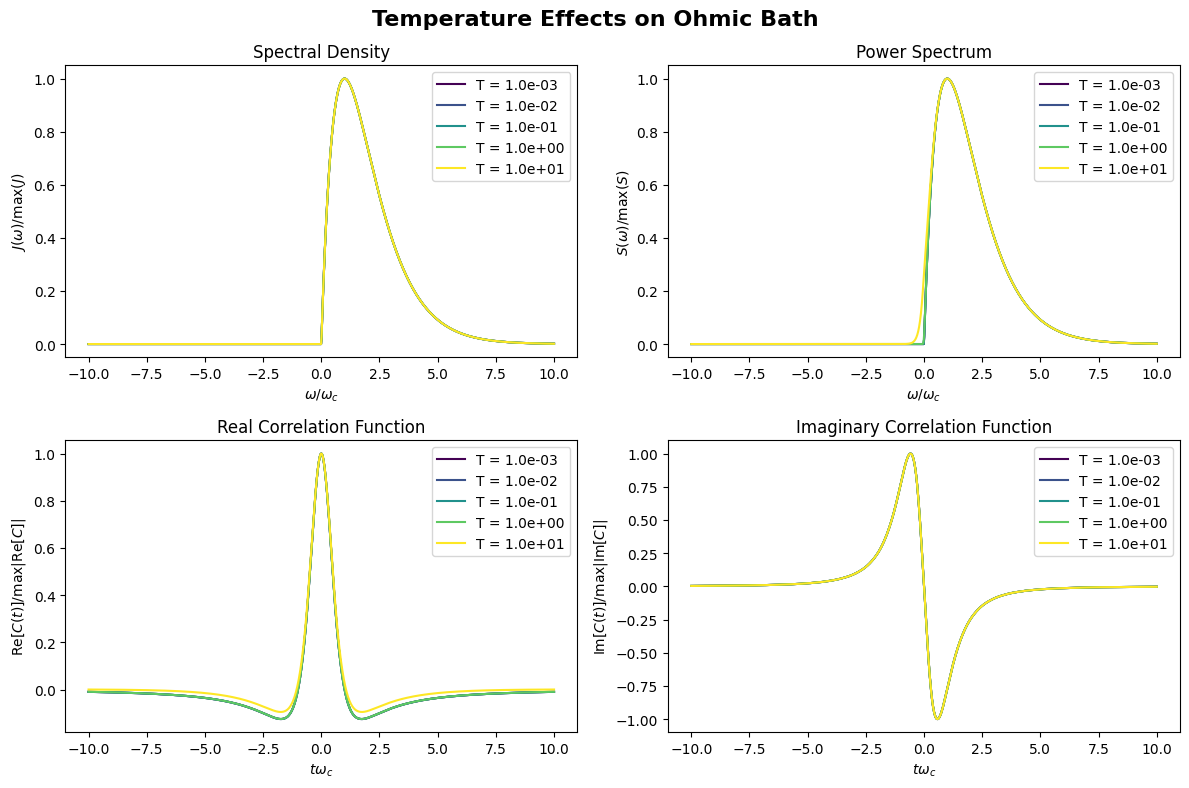

In [5]:
# =============================
# TEMPERATURE EFFECTS ANALYSIS
# =============================

def analyze_temperature_effects(bath_type='Paper Bath', temperatures=None):
    """Analyze how temperature affects bath properties"""
    
    if temperatures is None:
        temperatures = [1e-3, 1e-2, 1e-1, 1, 10]
    
    cutoff = 1e2
    eta = 1e-2
    frequencies = np.linspace(-10 * cutoff, 10 * cutoff, 1000)
    times = np.linspace(-10 / cutoff, 10 / cutoff, 1000)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f'Temperature Effects on {bath_type}', fontsize=16, fontweight='bold')
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(temperatures)))
    
    for i, temp in enumerate(temperatures):
        color = colors[i]
        
        # Update arguments with current temperature
        if bath_type == 'Paper Bath':
            args = {
                "g": np.sqrt(eta * cutoff),
                "cutoff": cutoff,
                "Boltzmann": Boltzmann,
                "hbar": hbar,
                "Temp": temp,
            }
            J_func = spectral_density_func_paper
            S_func = Power_spectrum_func_paper
        elif bath_type == 'Ohmic Bath':
            args = {
                "eta": eta,
                "cutoff": cutoff,
                "s": 1.0,
                "Boltzmann": Boltzmann,
                "Temp": temp,
            }
            J_func = spectral_density_func_ohmic
            S_func = Power_spectrum_func_ohmic
        
        # Calculate spectral density and power spectrum
        J_vals = np.array([J_func(w, args) for w in frequencies])
        S_vals = np.array([S_func(w, args) for w in frequencies])
        
        # Plot spectral density (should be temperature independent)
        J_max = np.max(np.abs(J_vals[J_vals > 0])) if np.any(J_vals > 0) else 1
        axes[0, 0].plot(frequencies / cutoff, J_vals / J_max, 
                       color=color, label=f'T = {temp:.1e}')
        
        # Plot power spectrum
        S_max = np.max(np.abs(S_vals)) if np.any(S_vals != 0) else 1
        axes[0, 1].plot(frequencies / cutoff, S_vals / S_max, 
                       color=color, label=f'T = {temp:.1e}')
        
        # Calculate and plot correlation function using QuTiP
        try:
            if bath_type == 'Paper Bath':
                env = BosonicEnvironment.from_power_spectrum(
                    lambda w: Power_spectrum_func_paper(w, args), 
                    wMax=10 * cutoff, T=temp
                )
            else:
                env = BosonicEnvironment.from_spectral_density(
                    lambda w: J_func(w, args), 
                    wMax=10 * cutoff, T=temp
                )
            
            correlation_vals = env.correlation_function(times)
            
            # Plot real part of correlation function
            C_max = np.max(np.abs(np.real(correlation_vals)))
            if C_max > 0:
                axes[1, 0].plot(times * cutoff, np.real(correlation_vals) / C_max, 
                               color=color, label=f'T = {temp:.1e}')
            
            # Plot imaginary part of correlation function
            C_imag_max = np.max(np.abs(np.imag(correlation_vals)))
            if C_imag_max > 0:
                axes[1, 1].plot(times * cutoff, np.imag(correlation_vals) / C_imag_max, 
                               color=color, label=f'T = {temp:.1e}')
                
        except Exception as e:
            print(f"⚠️ QuTiP error for T={temp}: {e}")
    
    # Set labels and titles
    axes[0, 0].set_xlabel(r'$ω / ω_c$')
    axes[0, 0].set_ylabel(r'$J(ω) / \max(J)$')
    axes[0, 0].set_title('Spectral Density')
    axes[0, 0].legend()
    
    axes[0, 1].set_xlabel(r'$ω / ω_c$')
    axes[0, 1].set_ylabel(r'$S(ω) / \max(S)$')
    axes[0, 1].set_title('Power Spectrum')
    axes[0, 1].legend()
    
    axes[1, 0].set_xlabel(r'$t ω_c$')
    axes[1, 0].set_ylabel(r'$\mathrm{Re}[C(t)] / \max|\mathrm{Re}[C]|$')
    axes[1, 0].set_title('Real Correlation Function')
    axes[1, 0].legend()
    
    axes[1, 1].set_xlabel(r'$t ω_c$')
    axes[1, 1].set_ylabel(r'$\mathrm{Im}[C(t)] / \max|\mathrm{Im}[C]|$')
    axes[1, 1].set_title('Imaginary Correlation Function')
    axes[1, 1].legend()

    plt.tight_layout()
    return fig, axes

# Create temperature analysis
print("🌡️ Analyzing temperature effects...")
fig_temp, axes_temp = analyze_temperature_effects('Paper Bath')
fig_temp, axes_temp = analyze_temperature_effects('Ohmic Bath')
plt.show()

🔬 Performing detailed correlation function analysis...
📊 Paper Bath: Decay time ≈ -0.25/ωc, C(0) = 1.59e+01
📊 Ohmic Bath: Decay time ≈ -0.25/ωc, C(0) = 3.18e+01


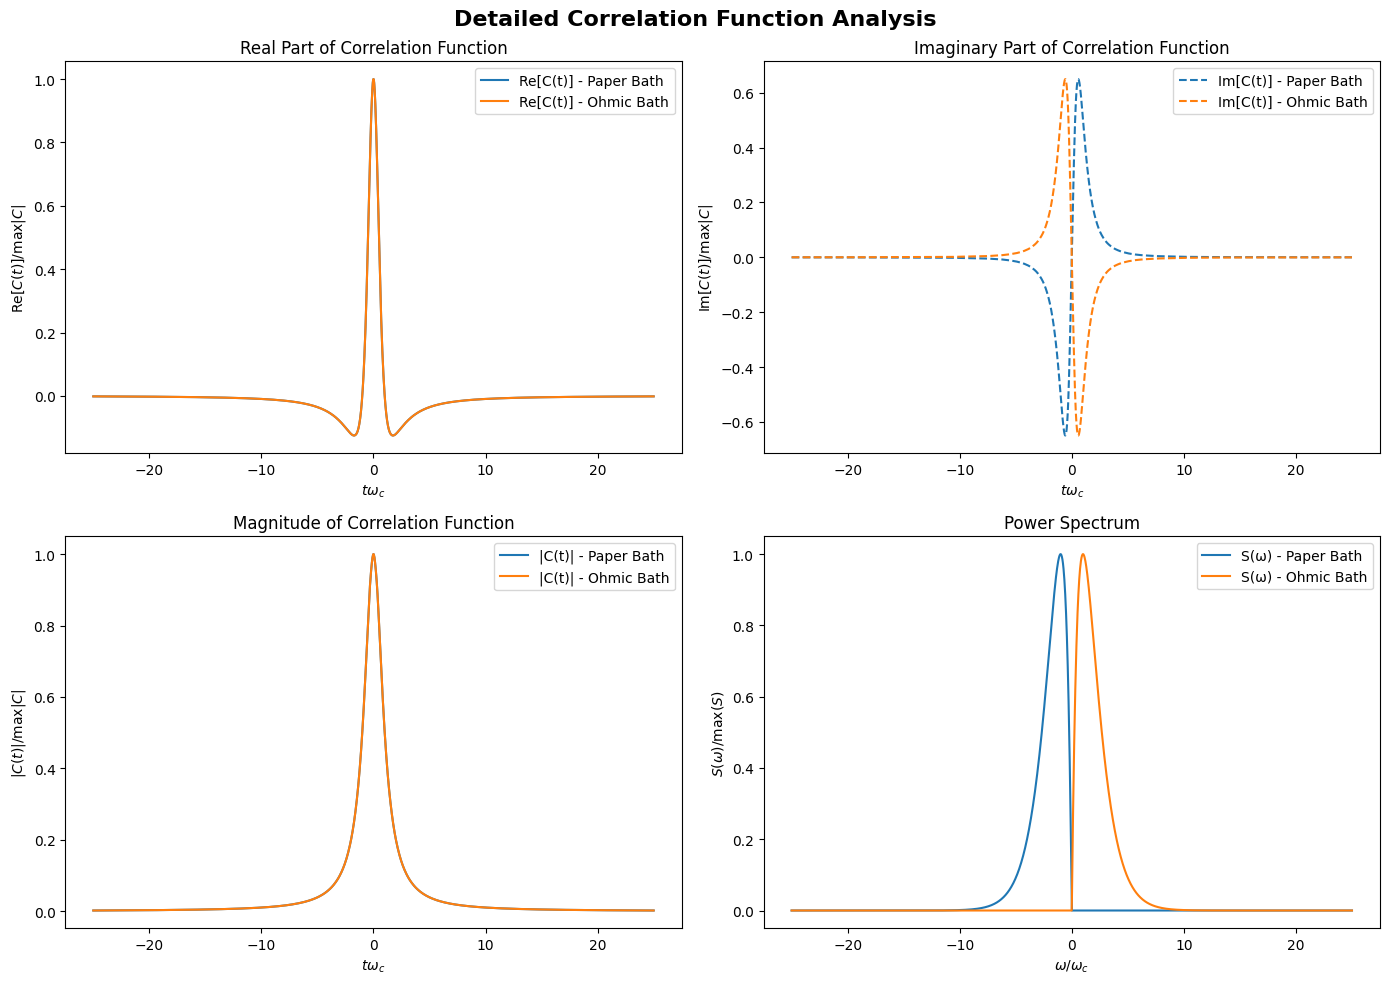

In [6]:
# =============================
# DETAILED CORRELATION FUNCTION ANALYSIS
# =============================

def detailed_correlation_analysis(frequencies_range=(-25, 25), num_points=2000):
    """Detailed analysis of correlation functions for different baths"""
    
    cutoff = args_paper["cutoff"]
    frequencies = np.linspace(
        frequencies_range[0] * cutoff, 
        frequencies_range[1] * cutoff, 
        num_points
    )
    times = np.linspace(
        frequencies_range[0] / cutoff, 
        frequencies_range[1] / cutoff, 
        num_points
    )
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Detailed Correlation Function Analysis', fontsize=16, fontweight='bold')
    
    # Bath configurations for correlation analysis
    bath_configs = [
        ("Paper Bath", args_paper, 'C0', Power_spectrum_func_paper),
        ("Ohmic Bath", args_ohmic, 'C1', spectral_density_func_ohmic),
    ]
    
    for i, (name, args, color, func) in enumerate(bath_configs):
        try:
            # Create QuTiP environment with array-compatible wrappers
            if name == "Paper Bath":
                def power_spectrum_wrapper(w):
                    if np.isscalar(w):
                        return func(w, args)
                    else:
                        return Power_spectrum_func_paper(w, args)
                
                env = BosonicEnvironment.from_power_spectrum(
                    power_spectrum_wrapper, 
                    wMax=10 * cutoff, T=args["Temp"]
                )
            else:
                def spectral_density_wrapper(w):
                    if np.isscalar(w):
                        return func(w, args)
                    else:
                        w_array = np.asarray(w)
                        return np.array([func(wi, args) for wi in w_array])
                
                env = BosonicEnvironment.from_spectral_density(
                    spectral_density_wrapper, 
                    wMax=10 * cutoff, T=args["Temp"]
                )
            
            correlation_vals = env.correlation_function(times)
            power_spectrum_vals = env.power_spectrum(frequencies)
            
            # Normalize for plotting
            C_max = np.max(np.abs(correlation_vals))
            S_max = np.max(np.abs(power_spectrum_vals))
            
            # Plot correlation function components
            axes[0, 0].plot(times * cutoff, np.real(correlation_vals) / C_max, 
                           color=color, label=f'Re[C(t)] - {name}', linestyle='-')
            axes[0, 1].plot(times * cutoff, np.imag(correlation_vals) / C_max, 
                           color=color, label=f'Im[C(t)] - {name}', linestyle='--')
            axes[1, 0].plot(times * cutoff, np.abs(correlation_vals) / C_max, 
                           color=color, label=f'|C(t)| - {name}', linestyle='-')
            
            # Plot power spectrum
            axes[1, 1].plot(frequencies / cutoff, power_spectrum_vals / S_max, 
                           color=color, label=f'S(ω) - {name}', linestyle='-')
            
            # Add some analysis text
            tau_decay = times[np.abs(correlation_vals) < C_max * np.exp(-1)][0] if len(times[np.abs(correlation_vals) < C_max * np.exp(-1)]) > 0 else float('inf')
            print(f"📊 {name}: Decay time ≈ {tau_decay:.2f}/ωc, C(0) = {C_max:.2e}")
            
        except Exception as e:
            print(f"⚠️ Error analyzing {name}: {e}")
    
    # Set labels and formatting
    axes[0, 0].set_xlabel(r'$t ω_c$')
    axes[0, 0].set_ylabel(r'$\mathrm{Re}[C(t)] / \max|C|$')
    axes[0, 0].set_title('Real Part of Correlation Function')
    axes[0, 0].legend()
    
    axes[0, 1].set_xlabel(r'$t ω_c$')
    axes[0, 1].set_ylabel(r'$\mathrm{Im}[C(t)] / \max|C|$')
    axes[0, 1].set_title('Imaginary Part of Correlation Function')
    axes[0, 1].legend()
    
    axes[1, 0].set_xlabel(r'$t ω_c$')
    axes[1, 0].set_ylabel(r'$|C(t)| / \max|C|$')
    axes[1, 0].set_title('Magnitude of Correlation Function')
    axes[1, 0].legend()
    
    axes[1, 1].set_xlabel(r'$ω / ω_c$')
    axes[1, 1].set_ylabel(r'$S(ω) / \max(S)$')
    axes[1, 1].set_title('Power Spectrum')
    axes[1, 1].legend()

    plt.tight_layout()
    return fig, axes

# Perform detailed correlation analysis
print("🔬 Performing detailed correlation function analysis...")
fig_corr, axes_corr = detailed_correlation_analysis()
plt.show()

## Summary and Insights

### Key Findings:

1. **Spectral Density $J(ω)$**: 
   - Paper bath: Exponential cutoff with linear frequency dependence
   - Ohmic bath: Power-law with exponential cutoff
   - Drude-Lorentz: Lorentzian peak structure

2. **Power Spectrum $S(ω)$**:
   - Temperature-dependent through Bose-Einstein distribution
   - Asymmetric around ω=0 due to detailed balance
   - Zero-frequency value $S(0) = k_B T g^2 / ω_c$ for paper bath

3. **Correlation Functions $C(t)$**:
   - Real part: Represents thermal fluctuations
   - Imaginary part: Related to dissipative dynamics
   - Decay time scales inversely with cutoff frequency

### Physical Interpretation:

- **Weak coupling regime**: $η ≪ 1$ ensures validity of Born-Markov approximation
- **High temperature**: Classical limit where $S(ω) ≈ S(-ω)$
- **Low temperature**: Quantum regime with strong frequency asymmetry

In [7]:
# =============================
# EXPORT AND SAVE FUNCTIONALITY
# =============================

def save_bath_data(filename_prefix="bath_analysis", 
                  frequencies_range=(-25, 25), 
                  num_points=2000):
    """Save calculated bath data for further analysis"""
    
    cutoff = args_paper["cutoff"]
    frequencies = np.linspace(
        frequencies_range[0] * cutoff, 
        frequencies_range[1] * cutoff, 
        num_points
    )
    
    # Calculate data for all baths
    data_dict = {}
    
    # Paper bath
    J_paper = np.array([spectral_density_func_paper(w, args_paper) for w in frequencies])
    S_paper = np.array([Power_spectrum_func_paper(w, args_paper) for w in frequencies])
    data_dict['paper'] = {
        'frequencies': frequencies,
        'J': J_paper,
        'S': S_paper,
        'args': args_paper
    }
    
    # Ohmic bath
    J_ohmic = np.array([spectral_density_func_ohmic(w, args_ohmic) for w in frequencies])
    S_ohmic = np.array([Power_spectrum_func_ohmic(w, args_ohmic) for w in frequencies])
    data_dict['ohmic'] = {
        'frequencies': frequencies,
        'J': J_ohmic,
        'S': S_ohmic,
        'args': args_ohmic
    }
    
    # Drude-Lorentz bath
    J_dl = np.array([spectral_density_func_drude_lorentz(w, args_drude_lorentz) for w in frequencies])
    data_dict['drude_lorentz'] = {
        'frequencies': frequencies,
        'J': J_dl,
        'args': args_drude_lorentz
    }
    
    # Save to numpy file
    import pickle
    with open(f"{filename_prefix}.pkl", 'wb') as f:
        pickle.dump(data_dict, f)
    
    print(f"💾 Bath data saved to {filename_prefix}.pkl")
    print(f"   Contains: {list(data_dict.keys())}")
    print(f"   Frequency range: {frequencies_range}")
    print(f"   Number of points: {num_points}")
    
    return data_dict

# Save current analysis
saved_data = save_bath_data()

💾 Bath data saved to bath_analysis.pkl
   Contains: ['paper', 'ohmic', 'drude_lorentz']
   Frequency range: (-25, 25)
   Number of points: 2000


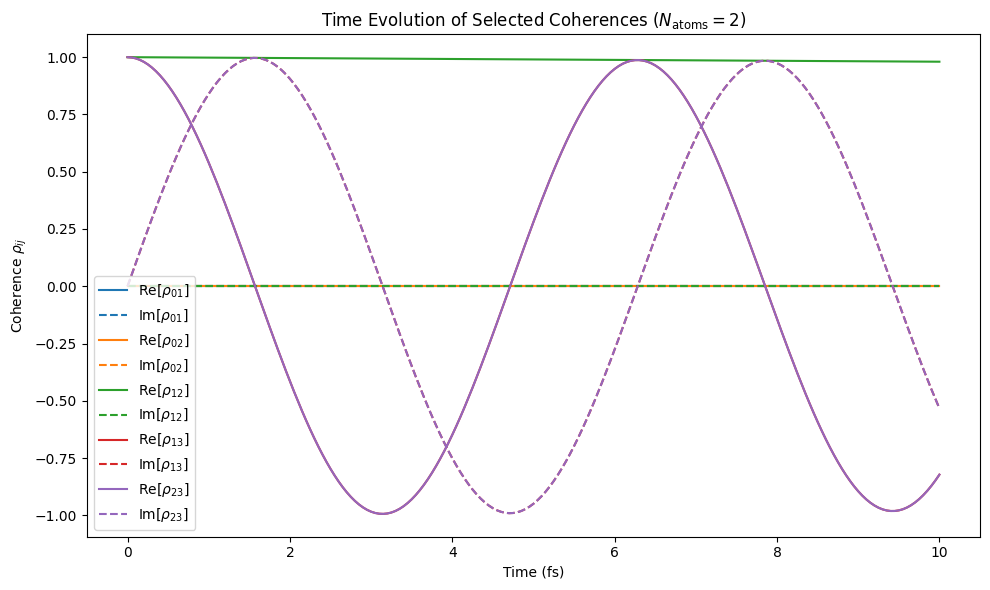

In [8]:
from qutip import basis, ket2dm, tensor, BosonicEnvironment, brmesolve
from src.baths.bath_fcts import spectral_density_func_paper, spectral_density_func_ohmic
atom_g = basis(2, 0)  # Ground state
atom_e = basis(2, 1)  # Excited state
N_atoms = 2
Temp = 1e-1 # Temperature in Kelvin
cutoff = 100.0  # Cutoff frequency in cm^-1
eta = 1  # Coupling strength 
Boltzmann = 1.0  # Boltzmann constant in cm^-1/K
hbar = 1.0  # Reduced Planck's constant in cm^-1*s

args_paper = {
    "g": np.sqrt(eta * cutoff),
    "cutoff": cutoff,
    "Boltzmann": Boltzmann,
    "hbar": hbar,
    "Temp": Temp,
}
# Ohmic bath parameters
c = {
    "eta": eta,
    "cutoff": cutoff,
    "s": 1.0,
    "Boltzmann": Boltzmann,
    "Temp": Temp,
}

env = BosonicEnvironment.from_spectral_density(
    lambda w: spectral_density_func_ohmic(w, args_ohmic),
    wMax=10 * cutoff,
    T=Temp,
)
a_ops_list = []  # List to hold operators for each atom
if N_atoms == 1:
    Deph_op = (atom_e * atom_e.dag())  # Dephasing operator
    a_ops_list = [
        [Deph_op, env.power_spectrum],
    ]  # TODO THIS WAS NOT IN THE PAPER!!!!

elif N_atoms == 2:
    a_ops_list = [
        [
            ket2dm(tensor(atom_e, atom_g)),  # atom A
            env.power_spectrum,
        ],  # atom A with ohmic_spectrum
        [
            ket2dm(tensor(atom_g, atom_e)),  # atom B
            env.power_spectrum,
        ],  # atom B with ohmic_spectrum
        [
            ket2dm(tensor(atom_e, atom_e)),  # double excited state
            lambda w: env.power_spectrum(2 * w),
        ],  # double excited state with 2 * ohmic_spectrum
    ]
else:
    raise ValueError("Only N_atoms=1 or 2 are supported.")
a_ops_list
times = np.linspace(0, 10, 201)  # Time array from 0 to 100 fs
if N_atoms == 1:
    H0 = ket2dm(atom_e)  # Single atom Hamiltonian
    psi0 = atom_e+atom_g  # Initial state: atom in excited state
else:
    H0 = 2 * ket2dm(tensor(atom_e, atom_e)) + 1 * ket2dm(tensor(atom_g, atom_e)) + 1 * ket2dm(tensor(atom_e, atom_g))  # Both atoms in excited state
    psi0 = tensor(atom_e, atom_e)+tensor(atom_e, atom_g)+tensor(atom_g, atom_e)  # Initial state: both atoms in excited state
result = brmesolve(H0, psi0, times, a_ops_list)
# =============================
# VISUALIZE BRMESOLVE COHERENCES
# =============================

# Extract coherences (off-diagonal elements) for each basis state from result.states
coherences = [state.full()[0, 1] for state in result.states]  # |0><1| element for each time step
coherences = np.array(coherences)  # shape: (len(times),)

plt.figure(figsize=(10, 6))

if N_atoms == 1:
    # For a single atom, plot the coherence between |g> and |e>
    plt.plot(times, np.real(coherences), label=r"$\mathrm{Re}[\rho_{01}]$", linestyle='solid', color='C0')
    plt.plot(times, np.imag(coherences), label=r"$\mathrm{Im}[\rho_{01}]$", linestyle='dashed', color='C1')
    plt.ylabel(r"Coherence $\rho_{01}$")
    plt.title(r"Time Evolution of Coherence $\rho_{01}$ ($N_\mathrm{atoms}=1$)")
else:
    # For two atoms, plot selected coherences in the 4x4 density matrix
    # |00>, |01>, |10>, |11> basis: indices 0,1,2,3
    coh_01 = np.array([state.full()[0, 1] for state in result.states])  # |00><01|
    coh_02 = np.array([state.full()[0, 2] for state in result.states])  # |00><10|
    coh_12 = np.array([state.full()[1, 2] for state in result.states])  # |01><10|
    coh_13 = np.array([state.full()[1, 3] for state in result.states])  # |01><11|
    coh_23 = np.array([state.full()[2, 3] for state in result.states])  # |10><11|

    plt.plot(times, np.real(coh_01), label=r"$\mathrm{Re}[\rho_{01}]$", linestyle='solid', color='C0')
    plt.plot(times, np.imag(coh_01), label=r"$\mathrm{Im}[\rho_{01}]$", linestyle='dashed', color='C0')
    plt.plot(times, np.real(coh_02), label=r"$\mathrm{Re}[\rho_{02}]$", linestyle='solid', color='C1')
    plt.plot(times, np.imag(coh_02), label=r"$\mathrm{Im}[\rho_{02}]$", linestyle='dashed', color='C1')
    plt.plot(times, np.real(coh_12), label=r"$\mathrm{Re}[\rho_{12}]$", linestyle='solid', color='C2')
    plt.plot(times, np.imag(coh_12), label=r"$\mathrm{Im}[\rho_{12}]$", linestyle='dashed', color='C2')
    plt.plot(times, np.real(coh_13), label=r"$\mathrm{Re}[\rho_{13}]$", linestyle='solid', color='C3')
    plt.plot(times, np.imag(coh_13), label=r"$\mathrm{Im}[\rho_{13}]$", linestyle='dashed', color='C3')
    plt.plot(times, np.real(coh_23), label=r"$\mathrm{Re}[\rho_{23}]$", linestyle='solid', color='C4')
    plt.plot(times, np.imag(coh_23), label=r"$\mathrm{Im}[\rho_{23}]$", linestyle='dashed', color='C4')
    plt.ylabel(r"Coherence $\rho_{ij}$")
    plt.title(r"Time Evolution of Selected Coherences ($N_\mathrm{atoms}=2$)")

plt.xlabel(r"Time (fs)")
plt.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()
